In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv(dotenv_path='./.env')

True

In [3]:
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
def draw_image_with_points(csv_file_path, image_file, folder_path='/content/drive/MyDrive/contest3/images/images/train'):
  # Путь к папке с изображениями

  # Чтение CSV-файла
  data = pd.read_csv(csv_file_path)

  # image_file = data['file_name'][index]

  # Получаем ключевые точки из CSV-файла для текущего изображения
  key_points_data = data.loc[data['file_name'] == image_file, ['left_eye_x', 'left_eye_y',
                                                              'right_eye_x', 'right_eye_y',
                                                              'mouth_x', 'mouth_y',
                                                               'left_ear_1_x', 'left_ear_1_y',
                                                               'left_ear_2_x', 'left_ear_2_y',
                                                               'left_ear_3_x', 'left_ear_3_y',
                                                               'right_ear_1_x', 'right_ear_1_y',
                                                               'right_ear_2_x', 'right_ear_2_y',
                                                               'right_ear_3_x', 'right_ear_3_y']].values[0]
  left_eye_x, left_eye_y, right_eye_x, right_eye_y, mouth_x, mouth_y, left_ear_1_x, left_ear_1_y, left_ear_2_x, left_ear_2_y, left_ear_3_x, left_ear_3_y, right_ear_1_x, right_ear_1_y, right_ear_2_x, right_ear_2_y, right_ear_3_x, right_ear_3_y  = key_points_data

  # Отображаем изображение с ключевыми точками
  image_path = os.path.join(folder_path, image_file)
  image = Image.open(image_path)
  plt.imshow(image)
  plt.scatter(left_eye_x, left_eye_y, s=50, c='r', marker='o')  # Отображаем левый глаз
  plt.scatter(right_eye_x, right_eye_y, s=50, c='r', marker='o')  # Отображаем правый глаз
  plt.scatter(mouth_x, mouth_y, s=50, c='r', marker='o')  # Отображаем рот
  plt.scatter(left_ear_1_x, left_ear_1_y, s=50, c='r', marker='o')
  plt.scatter(left_ear_2_x, left_ear_2_y, s=50, c='r', marker='o')
  plt.scatter(left_ear_3_x, left_ear_3_y, s=50, c='r', marker='o')
  plt.scatter(right_ear_1_x, right_ear_1_y, s=50, c='r', marker='o')
  plt.scatter(right_ear_2_x, right_ear_2_y, s=50, c='r', marker='o')
  plt.scatter(right_ear_3_x, right_ear_3_y, s=50, c='r', marker='o')
  plt.show()



In [4]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

In [30]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, has_labels=True):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.has_labels = has_labels

        if self.has_labels:
            self.img_labels = pd.read_csv(annotations_file)
        else:
            self.image_files = os.listdir(img_dir)

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        if self.has_labels:
            listdir = os.listdir(self.img_dir)
            file_name = listdir[idx]
            img_path = os.path.join(self.img_dir, file_name)

            row = self.img_labels[self.img_labels['file_name'] == file_name]
            label = torch.tensor(row.iloc[0, :-1].values.astype(float))
            # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, -1])
            # label = torch.tensor(self.img_labels.iloc[idx, :-1])
        else:
            img_path = os.path.join(self.img_dir, self.image_files[idx])
            label = None

        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.has_labels:
          return image.float(), label.float()
        else:
          return image.float(), torch.empty(()).float()

In [77]:
def resize_train_data(img_train_dir, annotations_file):
  df = pd.read_csv(annotations_file)

  folder_path = path.join(os.sep, os.getenv("PATH_TO_DATA"), 'images/images/train_resized')


  for filename in os.listdir(img_train_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Полный путь к файлу
        file_path = os.path.join(img_train_dir, filename)

        # Открытие изображения
        image = Image.open(file_path)
        image_size = image.size

        # Изменение размера изображения до 256x256
        resized_image = image.resize((256, 256))
        resized_image_size = resized_image.size

        x_change = resized_image_size[0] / image_size[0]
        y_change = resized_image_size[1] / image_size[1]

        row = df[df['file_name'] == filename]

        for column_name in row.columns.tolist():
            if column_name.endswith('x'):
                df.loc[df['file_name'] == filename, column_name] *= x_change
            elif column_name.endswith('y'):
                df.loc[df['file_name'] == filename, column_name] *= y_change

        # Сохранение измененного изображения
        resized_image.save(os.path.join(path.join(os.getenv("PATH_TO_DATA"), "images/images/train_resized"), filename))

  df.to_csv(os.path.join(os.getenv("PATH_TO_DATA"), 'train_labels_resized.csv'), index=False)




In [10]:
def resize_test_data(img_train_dir):

  folder_path = os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/test_resized')

  dict_koefs = {}

  for filename in os.listdir(img_train_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Полный путь к файлу
        file_path = os.path.join(img_train_dir, filename)

        # Открытие изображения
        image = Image.open(file_path)
        image_size = image.size

        # Изменение размера изображения до 256x256
        resized_image = image.resize((256, 256))
        resized_image_size = resized_image.size

        x_change = resized_image_size[0] / image_size[0]
        y_change = resized_image_size[1] / image_size[1]

        koefs = []
        koefs.append(x_change)
        koefs.append(y_change)

        dict_koefs[filename] = koefs

  return dict_koefs


In [7]:
file_path = os.getenv('PATH_TO_DATA')

annotations_file = os.path.join(os.sep, file_path, 'train_labels.csv')
img_train_dir = os.path.join(os.sep, file_path, 'images/images/train')
img_test_dir = os.path.join(os.sep, file_path, 'images/images/test')

In [80]:
resize_train_data(img_train_dir, annotations_file) # ресайзим тренировочные данные

In [11]:
dict_koefs = resize_test_data(img_test_dir) # ресайзим тестовые данные и кладем коэффициенты ресайза в словарик

In [12]:
print(dict_koefs)

{'00271b0b4a63cd445eb573b955c13436.jpg': [0.25, 0.3333333333333333], '0122897dbb3886ced713c9e1834e299d.jpg': [0.512, 0.64], '015e123029f3d243c4d96de7e47dc0b9.jpg': [0.25, 0.3803863298662704], '0176c49df9745e5f2b1bfa5bec219739.jpg': [0.7804878048780488, 0.512], '018241810afc650fdb27922b96d5b3c1.jpg': [0.512, 0.6826666666666666], '01d4ff9f50e875364e3cdf1037eb1d54.jpg': [0.25, 0.3333333333333333], '027a51cc25118fbb3164aeb3b2315333.jpg': [0.6580976863753213, 0.512], '02b8035d98f675aeca8b4e043afa743f.jpg': [0.25, 0.375366568914956], '02d539fae26299ea44c757056acffe17.jpg': [0.3333333333333333, 0.25], '0396c0b5cc6f581af9b4ece078623ef5.jpg': [0.25, 0.3333333333333333], '039fadb5cd5919b1462f9296e11ab03e.jpg': [0.512, 0.6736842105263158], '03b6a01f1e8e93334ad15f8287f0f066.jpg': [0.512, 0.6826666666666666], '03c226e2e01ea9f1ce703f9ea9367a44.jpg': [0.6844919786096256, 0.512], '03eee6458eb21b3e0276056ad9d47e30.jpg': [0.25, 0.41898527004909986], '03fd371c819b188f3cb8f9f05b138643.jpg': [0.68266666666

In [81]:
from sklearn.model_selection import train_test_split
import random

def split_train_data():
  # Путь к папке с изображениями
  folder_path = img_train_dir = os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/train_resized')

  # Получение списка имен файлов из папки
  file_names = os.listdir(folder_path)

  # Перемешивание списка имен файлов
  random.shuffle(file_names)

  # Разделение на тренировочную и валидационную выборки
  train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

  # Перемещение файлов в соответствующие папки
  train_folder = folder_path # оставляем в этой же папке
  val_folder = os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/val_resized')

  for file_name in train_files:
      src = os.path.join(folder_path, file_name)
      dst = os.path.join(train_folder, file_name)
      os.rename(src, dst)

  for file_name in val_files:
      src = os.path.join(folder_path, file_name)
      dst = os.path.join(val_folder, file_name)
      os.rename(src, dst)

In [84]:
split_train_data()

In [118]:
def mult_preds(preds_df, dict_koefs): # функция возвращающая предсказания к начальным координатам

  for index, row in preds_df.iterrows():
    x_change = dict_koefs[row['file_name']][0]
    y_change = dict_koefs[row['file_name']][1]

    for column_name, _ in row.iteritems():
        if column_name.endswith('x'):
            preds_df.at[index, column_name] /= x_change
        elif column_name.endswith('y'):
            preds_df.at[index, column_name] /= y_change

  return preds_df

In [117]:
def get_val_tensor(img_dir, annotations_file): # возвращает тензор из точек изображений валидационных данных
  df = pd.read_csv(annotations_file)

  listdir = os.listdir(img_dir)

  val_tensor = torch.empty(0, 18)

  for file_name in listdir:
    row = df[df['file_name'] == file_name].iloc[0, :-1]
    row_tensor = torch.tensor(row.values.astype(float))
    val_tensor = torch.cat((val_tensor, row_tensor.unsqueeze(0)), dim=0)

  return val_tensor

In [129]:
def predict_values(net, img_dir):
  # Загрузка тестового датасета с использованием класса CustomImageDataset

  test_dataset = CustomImageDataset(annotations_file=None,
                                    img_dir=img_dir,
                                    has_labels=False)

  # Создание дата-лоадера для тестового датасета
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

  # Перевод модели в режим оценки (evaluation mode)
  net.eval()

  # Цикл по тестовым данным
  predictions = []
  for inputs, _ in test_dataloader:
      # Передача данных через модель для получения предсказаний
      # inputs = inputs.to('cuda')
      outputs = net(inputs)
      predictions.append(outputs.detach().numpy())

  # Объединение предсказаний в один массив
  predictions = np.concatenate(predictions, axis=0)

  # Вывод предсказаний
  return torch.tensor(predictions)


In [130]:
from IPython import display
from tqdm import tqdm

def training(net, n_epochs, optimizer, scheduler, criterion, dataloader):
  loss_history = []
  val_loss_history = []
  val_tensor = get_val_tensor(os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/val_resized'),
                          os.path.join(os.getenv("PATH_TO_DATA"), 'train_labels_resized.csv'))

  for i in range(n_epochs):
    progress_bar = tqdm(dataloader, desc=f'Epoch {i+1}/{n_epochs}', unit='batch')
    for x_batch, y_batch in progress_bar:

      # x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')

      predictions = net(x_batch)
      loss = criterion(predictions.squeeze(), y_batch.squeeze())

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()
      scheduler.step(loss)

      loss_history.append(loss.item())

    file_name = "net_parameters_" + str(i)

    preds = predict_values(net, os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/val_resized'))

    loss_fn = nn.L1Loss()

    l1_loss = loss_fn(val_tensor.squeeze(), preds.squeeze())
    val_loss_history.append(l1_loss.item())

    # Сохраните параметры модели в файл
    torch.save(net.state_dict(), os.path.join(os.getenv("PATH_TO_DATA"), file_name))


  plt.figure(figsize=(8,6))

  plt.title("Training loss")
  plt.xlabel("#iteration")
  plt.ylabel("loss")
  plt.plot(loss_history, 'b')
  plt.show()

  print('Current loss: %f' % loss)

  return sum(val_loss_history) / len(val_loss_history)

In [121]:
import torch.nn as nn

In [143]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        layers = [ # архитектура нейросети
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(131072, 128),
            nn.ReLU(),
            nn.Linear(128, 18)
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [132]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [133]:
new_annotations_file = os.path.join(os.sep, file_path, 'train_labels_resized.csv')
new_img_train_dir = os.path.join(os.sep, file_path, 'images/images/train_resized')

In [134]:
train_dataset = CustomImageDataset(annotations_file=new_annotations_file,
                                   img_dir=new_img_train_dir)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

In [144]:
import optuna

def objective(trial):
    step_size = trial.suggest_int('step_size', 1, 10)
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)
    n_epochs = 1

    # net = MyNet()
    # optimizer = optim.Adam(net.parameters(), lr=lr)
    # criterion = nn.L1Loss()
    # scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    # dataloader = train_dataloader

    net = MyNet(True,True,0.1442738408207127)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.L1Loss()
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    dataloader = train_dataloader


    # device = 'cuda'
    # net.to(device);

    mean_val_loss = training(net, n_epochs, optimizer, scheduler, criterion, dataloader)
    # net.to('cpu');
    # mean_val_loss.to('cpu')
    return mean_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

study.best_params

[I 2024-01-08 01:01:17,647] A new study created in memory with name: no-name-1b427007-ce25-41b5-8450-364f21c475b0
[W 2024-01-08 01:01:17,650] Trial 0 failed with parameters: {'step_size': 6, 'lr': 0.0003158349644105317, 'gamma': 0.38175200188907465} because of the following error: TypeError('MyNet.__init__() takes 1 positional argument but 4 were given').
Traceback (most recent call last):
  File "f:\PyTorchTest\venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\admin\AppData\Local\Temp\ipykernel_20500\3359325508.py", line 15, in objective
    net = MyNet(True,True,0.1442738408207127)
TypeError: MyNet.__init__() takes 1 positional argument but 4 were given
[W 2024-01-08 01:01:17,652] Trial 0 failed with value None.


TypeError: MyNet.__init__() takes 1 positional argument but 4 were given

In [145]:
def objective(trial):
    step_size = trial.suggest_int('step_size', 1, 10)
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)
    n_epochs = 1

    net = MyNet()  # Передача аргументов в конструктор MyNet
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.L1Loss()
    #scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    dataloader = train_dataloader

    device = 'cpu'  # изменение устройства на CPU
    net.to(device)

    mean_val_loss = training(net, n_epochs, optimizer, None, criterion, dataloader)  # Предполагается, что у вас есть функция training
    net.to('cpu')
    return mean_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-01-08 01:01:22,276] A new study created in memory with name: no-name-80344967-fe37-4f1e-8a33-065ec4bff49c
Epoch 1/1:   0%|          | 0/900 [00:00<?, ?batch/s]
[W 2024-01-08 01:01:26,069] Trial 0 failed with parameters: {'step_size': 1, 'lr': 0.00016432552569160903, 'gamma': 0.26355290895437866} because of the following error: AttributeError("'NoneType' object has no attribute 'step'").
Traceback (most recent call last):
  File "f:\PyTorchTest\venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\admin\AppData\Local\Temp\ipykernel_20500\2759583783.py", line 16, in objective
    mean_val_loss = training(net, n_epochs, optimizer, None, criterion, dataloader)  # Предполагается, что у вас есть функция training
  File "C:\Users\admin\AppData\Local\Temp\ipykernel_20500\3339929892.py", line 23, in training
    scheduler.step(loss)
AttributeError: 'NoneType' object has no attribute 'step'
[W 2024-01-08 01:01:26,071

AttributeError: 'NoneType' object has no attribute 'step'

In [136]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

Epoch 1/1: 100%|██████████| 900/900 [06:55<00:00,  2.16batch/s]


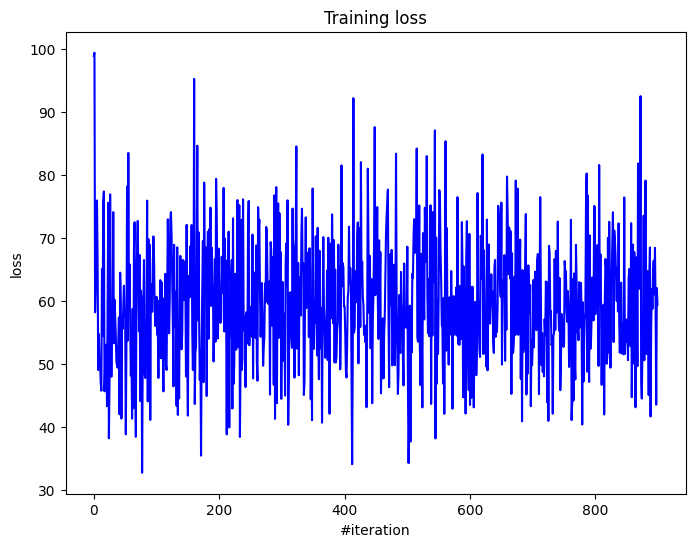

Current loss: 59.386848
70.15793828683427


In [138]:
n_epochs = 1
net = MyNet(True,True,0.1442738408207127)
optimizer = optim.Adam(net.parameters(), lr=0.0025455137675729077)
criterion = nn.L1Loss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=1e-4, cooldown=0, min_lr=0, eps=1e-8, verbose=False)
dataloader = train_dataloader

mean_val_loss = training(net, n_epochs, optimizer,scheduler, criterion, dataloader)
print(mean_val_loss)